In [43]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import sys
# add root folder to path
sys.path.append('../../')
from training.data.datasets import load_json_data
from tqdm import tqdm
import seaborn as sns
from IPython.display import Markdown
import random

# Data Loading
## Raw Data (that was annotated)

In [44]:
with open("results/data_used_for_annotation_with_chatgpt.jsonl") as f:
    raw_articles = [json.loads(line) for line in f]
raw_articles = pd.DataFrame(raw_articles)
print("Shape:",raw_articles.shape)
print("Categories:",sorted(raw_articles["category"].unique()))
raw_articles.head()

Shape: (1974, 6)
Categories: ['3d_printed_apparel', '3d_printed_food', '3d_printing', 'animal_rights', 'artificial_intelligence', 'autonomous_transport', 'biking', 'biophilia', 'blockchain', 'capsule_wardrobe', 'car_sharing', 'carbon_price', 'cement_production', 'chemicals_production', 'circular_economy', 'city_planning', 'clothes_designed_for_a_circular_economy', 'compact_living', 'daylight_architecture', 'dematerialisation', 'digital_solutions_to_regulate_food_intake_and_nutrition', 'drone', 'e_health', 'ecosophy', 'electric_car', 'energy_storage', 'fiber_optic_cables', 'flight_shame', 'food_waste_management_solutions', 'grid_parity', 'half_earth', 'heating_and_cooling', 'hologram', 'hydropower', 'insulation', 'led', 'local_vacations', 'low_energy_demand', 'low_impact_living', 'meat_shame', 'meatfree_plant_based_biotech', 'modular_design', 'nanotechnology', 'new_living_concepts', 'organic_food', 'plus_energy_buildings', 'public_transport', 'rent_apparel', 'scope_for_avoided_emissions

,id,title,text,category,climate_scanner,old_id
0,0,The Shattering Truth of 3D-Printed Clothing,When the fashion trio threeASFOUR debuted its ...,3d_printed_apparel,True,0
1,1,Soon you may be able to 3D print clothing in y...,Three-dimensional printing has changed the way...,3d_printed_apparel,True,1
2,2,A clothing startup founded by MIT grads is usi...,The Insider Picks team writes about stuff we t...,3d_printed_apparel,True,4
3,3,3D Printing of Clothing,3D Printing of Clothing\nThe technology behind...,3d_printed_apparel,True,5
4,4,3D printed fashion: Why is additive manufactur...,3D printed fashion: Why is additive manufactur...,3d_printed_apparel,True,6


## Human Annotated Data

In [45]:
# get old already annotated data
old_data = load_json_data("../../datasets")
old_data = old_data.rename(columns={"sentence_id": "section_id"})
print(old_data.shape)

Loaded: fiber_optic_cables_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: cement_production_sentences.jsonl


Loaded: e_health_sentences.jsonl


(9416, 5)


## Predictions / Annotations

In [46]:
# load predictions.jsonl from current folder
with open("results/predictions.jsonl") as f:
    preds = [json.loads(line) for line in f]
preds = {list(p.keys())[0]:p[list(p.keys())[0]] for p in preds}
new_rows = []
for article_id, section_predictions in preds.items():
    if raw_articles.iloc[int(article_id)]["old_id"] in set(old_data.article_id.values):
        # human annotation already exists, skip
        continue
    for section_pred in section_predictions:
        new_row = {
            "article_id": article_id,
            "article_id _old": raw_articles.iloc[int(article_id)]["old_id"],
            "section_id": section_pred["section_id"],
            "section_category": section_pred["category"],
            "article_category": raw_articles.iloc[int(article_id)]["category"],
            "text": section_pred["text"],
            "reasoning": section_pred["reasoning"],
            "explanation": section_pred["explanation"],
        }
        new_rows.append(new_row)
predictions = pd.DataFrame(new_rows)
print("Shape:",predictions.shape)
predictions

Shape: (40391, 8)


,article_id,article_id _old,section_id,section_category,article_category,text,reasoning,explanation
0,21,23,0,3d_printing,3d_printing,The Benefits of 3D Printing: Remote Production...,The article segment focuses on how 3D printing...,{'0': {'prediction_1': {'category': '3d_printi...
1,21,23,1,3d_printing,3d_printing,How is it creating a new paradigm? How can it ...,The section focuses on discussing the benefits...,{'0': {'prediction_1': {'category': '3d_printi...
2,21,23,2,3d_printing,3d_printing,Read the previous episodes of our Benefits of ...,The article segment focuses on the history and...,{'0': {'prediction_1': {'category': '3d_printi...
3,21,23,3,3d_printing,3d_printing,"Since then, 3D printing has brought a deep and...",The section discusses the impact of 3D printin...,{'0': {'prediction_1': {'category': '3d_printi...
4,21,23,4,3d_printing,3d_printing,Machines are connected thanks to the Internet ...,The section clearly discusses the benefits of ...,{'0': {'prediction_1': {'category': '3d_printi...
...,...,...,...,...,...,...,...,...
40386,1973,2716,9,sustainable_agriculture_production,3d_printed_food,It allows both groups to upload and download r...,The section focuses on a platform that enables...,{'0': {'prediction_1': {'category': 'sustainab...
40387,1973,2716,10,sustainable_agriculture_production,3d_printed_food,"As a result of the program, farmers’ income ha...",The section discusses the positive impact on f...,"{'1': {'prediction_1': {'category': 'unsure', ..."
40388,1973,2716,11,none,3d_printed_food,COVID-19 has posed new challenges for the orga...,The article section does not align with any of...,"{'0': {'prediction_1': {'category': 'unsure', ..."
40389,1973,2716,12,sustainable_agriculture_production,3d_printed_food,Some organizations currently partnered with Di...,The section emphasizes the importance of small...,{'0': {'prediction_1': {'category': 'sustainab...


# Analysis of results
## Check for categories that don't exist

In [47]:
true_categories = raw_articles.category.unique()
predicted_categories = predictions.section_category.unique()
fictional_categories = [cat for cat in predicted_categories if cat not in true_categories and cat != "unsure" and cat != "none"]
print("True categories: ")
print(sorted(true_categories))
print("Predicted categories: ")
print(sorted(predicted_categories))
print("Fictional categories:")
print(sorted(fictional_categories))
print("Number of predictions with fictional categories: ", len(predictions[predictions.section_category.isin(fictional_categories)]))

True categories: 
['3d_printed_apparel', '3d_printed_food', '3d_printing', 'animal_rights', 'artificial_intelligence', 'autonomous_transport', 'biking', 'biophilia', 'blockchain', 'capsule_wardrobe', 'car_sharing', 'carbon_price', 'cement_production', 'chemicals_production', 'circular_economy', 'city_planning', 'clothes_designed_for_a_circular_economy', 'compact_living', 'daylight_architecture', 'dematerialisation', 'digital_solutions_to_regulate_food_intake_and_nutrition', 'drone', 'e_health', 'ecosophy', 'electric_car', 'energy_storage', 'fiber_optic_cables', 'flight_shame', 'food_waste_management_solutions', 'grid_parity', 'half_earth', 'heating_and_cooling', 'hologram', 'hydropower', 'insulation', 'led', 'local_vacations', 'low_energy_demand', 'low_impact_living', 'meat_shame', 'meatfree_plant_based_biotech', 'modular_design', 'nanotechnology', 'new_living_concepts', 'organic_food', 'plus_energy_buildings', 'public_transport', 'rent_apparel', 'scope_for_avoided_emissions', 'sharing

### Correct for categories that don't exist

In [48]:
# this is hand crafted
correction_mapping = {
    "autonomous transport": "autonomous_transport",
    "electric_vehicles": "electric_car",
}
# apply mapping
predictions.loc[:,"section_category"] = predictions["section_category"].apply(lambda x: correction_mapping[x] if x in correction_mapping else x)
# drop fictional categories
predictions = predictions[~predictions.section_category.isin(fictional_categories)]

## Inspect "unsure" and "none" labels

In [49]:
unclear_predictions = predictions.loc[predictions.section_category.isin(["none","unsure"])]
unclear_predictions.reset_index(drop=True, inplace=True)
# plot count of bad predictions per article id
print("Total number of unclear predictions: ", unclear_predictions.shape[0])

Total number of unclear predictions:  4705


Text(0.5, 1.0, 'Count of bad predictions per article level category')

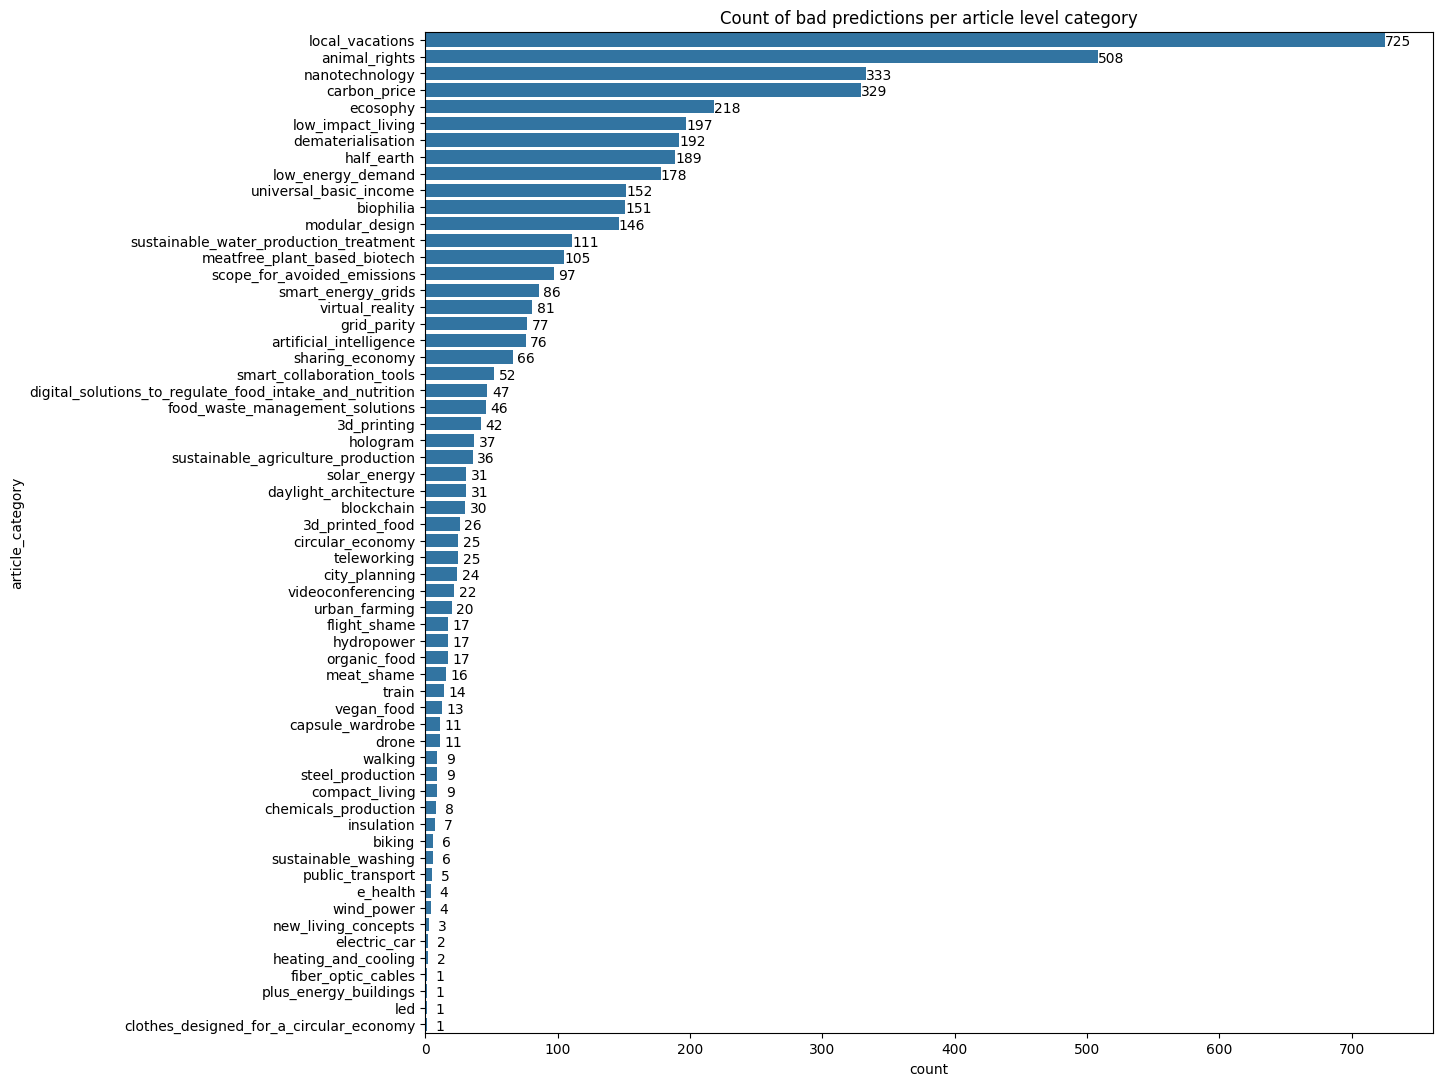

In [50]:
# get count by article level category   
count_per_article_category = unclear_predictions["article_category"].value_counts().reset_index()
# plot count of bad predictions per article level category
plt.figure(figsize=(13, 13))
ax = sns.barplot(x="count", y="article_category", data=count_per_article_category)
# add numbers to the bars
for p in ax.patches:
    width = p.get_width()
    plt.annotate(f'{int(width)}', (width + 10, p.get_y() + 0.5), ha='center', va='center')
# set title
plt.title("Count of bad predictions per article level category")

In [51]:
# What are those?
local_vacations = raw_articles[raw_articles["category"] == "local_vacations"]

In [52]:
# choose random row from unclear predictions
fixed_category = "local_vacations"
if fixed_category != "":
    row = unclear_predictions[unclear_predictions.article_category == fixed_category].iloc[random.randint(0, len(unclear_predictions[unclear_predictions.article_category == fixed_category])-1)]
else:
    row = unclear_predictions.iloc[random.randint(0, len(unclear_predictions)-1)]
print(f"----- Article {row.article_id} - Section {row.section_id}")
print(f"----- Title: {raw_articles.iloc[int(row.article_id)]['title']}")
print(f"----- Final predicted category: {row.section_category}, because: {row.reasoning}")
print(f"----- Article level category: {row.article_category}")
print(f"----- Text: {row.text}")
for annotator_id, conversation in row.explanation.items():
    print(f"\nAnnotator #{annotator_id}")
    for idx, (msg_type, msg) in enumerate(conversation.items()):
        if msg_type.startswith("prediction"):
            print(f"{'-'*(idx+1)} Chosen category: {msg['category']}")
            print(f"{'-'*(idx+1)} Reasoning: {msg['reasoning']}")
        else:
            print(f"{'-'*(idx+1)} The evaluator responded and claimed the annotation as '{msg['conclusion']}'.")
            print(f"{'-'*(idx+1)} Their reasoning: {msg['reasoning']}")

----- Article 1828 - Section 152
----- Title: Existential Climate-Related Security Risk
----- Final predicted category: unsure, because: The article section discusses a hypothetical scenario where individuals with significant wealth may be considering active malevolent actions due to overpopulation concerns. This falls under the category of 'Social Issues and Ethics' as it addresses the ethical implications of such thoughts. The other categories are not as well-suited because the section goes beyond individual protection and addresses broader social and ethical considerations.
----- Article level category: local_vacations
----- Text: Nobody's thinking that, afaik, they're just thinking what I'm thinking that anybody with ridiculous money is probably trying to spend it on protecting himself and his way of life and maybe some progeny. But what if it's more actively malevolent than that? What if they looked at it and thought: "There's too many of us in this species.

Annotator #0
- Chosen

In [53]:
# label unsure predictions as "irrelevant"
predictions.loc[(predictions.section_category.isin(["unsure","none"])), "section_category"] = "irrelevant"
print("Final number of predictions: ", predictions.shape[0])

Final number of predictions:  40382


## Final Label Distribution

In [54]:
# count samples per label
print("Number of categories:", predictions.section_category.nunique())
predictions.section_category.value_counts()

Number of categories: 71


section_category
irrelevant                                        4705
sustainable_agriculture_production                3561
smart_collaboration_tools                         1447
carbon_price                                      1335
sustainable_water_production_treatment            1273
                                                  ... 
smart_food_management_kitchen_fridges_freezers      45
cement_production                                   40
car_sharing                                         29
e_health                                            13
fiber_optic_cables                                   5
Name: count, Length: 71, dtype: int64

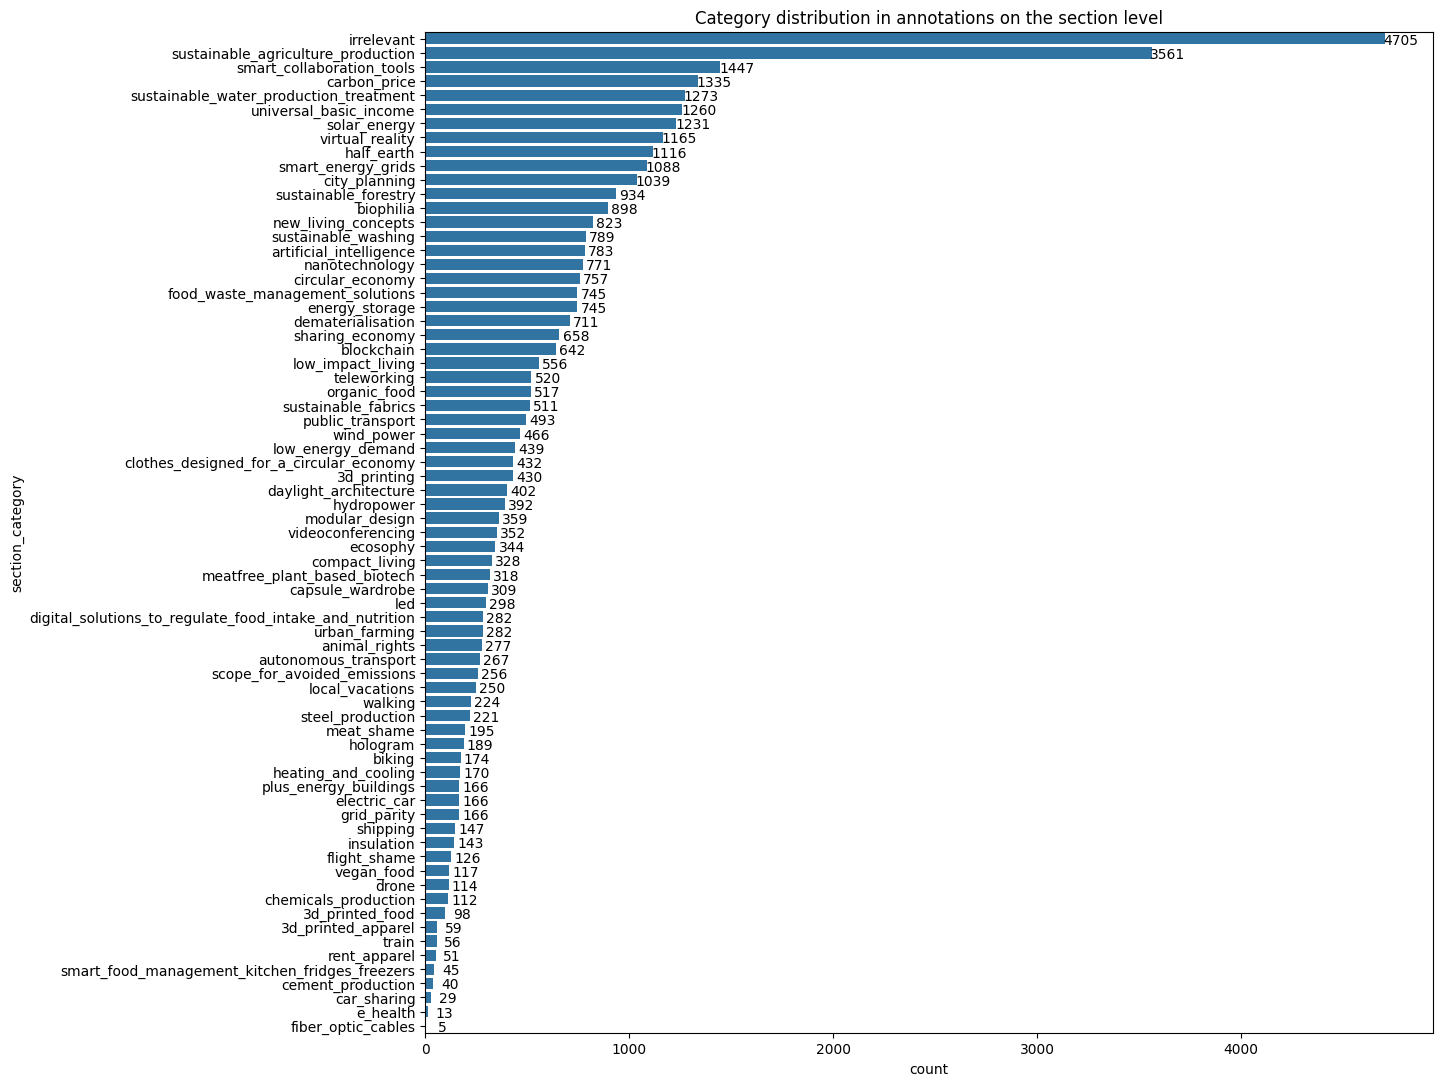

In [55]:
plt.figure(figsize=(13, 13))
ax = sns.countplot(y="section_category", data=predictions, order=predictions.section_category.value_counts().index)
plt.title("Category distribution in annotations on the section level")
# Add numbers to the bars
for p in ax.patches:
    width = p.get_width()
    plt.annotate(f'{int(width)}', (width + 80, p.get_y() + 0.5), ha='center', va='center')
plt.show()


# Save data

In [56]:
final_dataset = []
progress_bar = tqdm(total=predictions.shape[0])
progress_bar.set_description("Processing")
count_skipped = 0
for idx, row in predictions.iterrows():
    article_id = int(row.article_id)
    section_id = row.section_id
    label = row.section_category
    text = row.text
    spans = []
    new_row = {
        "article_id": article_id,
        "section_id": section_id,
        "label": label,
        "text": text,
        "spans": spans
    }
    final_dataset.append(new_row)
    progress_bar.update(1)
final_dataset = pd.DataFrame(final_dataset)
print(final_dataset.shape)
final_dataset.head()

(40382, 5)


,article_id,section_id,label,text,spans
0,21,0,3d_printing,The Benefits of 3D Printing: Remote Production...,[]
1,21,1,3d_printing,How is it creating a new paradigm? How can it ...,[]
2,21,2,3d_printing,Read the previous episodes of our Benefits of ...,[]
3,21,3,3d_printing,"Since then, 3D printing has brought a deep and...",[]
4,21,4,3d_printing,Machines are connected thanks to the Internet ...,[]


In [57]:
final_dataset.to_parquet("../../datasets/openai_annotated_data.parquet")